DATA 1030 Project 1: Predicting Population Growth Rates by Country

Step 0: Import Packages

In [226]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, neighbors, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

# plt.style.use('seaborn-whitegrid')

Step 1: Read Data

In [227]:
growth_rate = pd.read_csv('/Users/chuwu/Desktop/project1/datasets/population_growth_annual_percent.csv')
mortality = pd.read_csv('/Users/chuwu/Desktop/project1/datasets/child_mortality_0_5_year_olds_dying_per_1000_born.csv')
birth_rate = pd.read_excel('/Users/chuwu/Desktop/project1/datasets/birth_rate.xls')
death_rate = pd.read_excel('/Users/chuwu/Desktop/project1/datasets/death_rate.xls')
income = pd.read_csv('/Users/chuwu/Desktop/project1/datasets/income_per_person_gdppercapita_ppp_inflation_adjusted.csv')
gdp_cap = pd.read_csv('/Users/chuwu/Desktop/project1/datasets/gdppercapita_us_inflation_adjusted.csv')
gdp = pd.read_csv('/Users/chuwu/Desktop/project1/datasets/total_gdp_us_inflation_adjusted.csv')
population = pd.read_csv('/Users/chuwu/Desktop/project1/datasets/population_total.csv')

In [228]:
birth_rate = birth_rate.drop(['Country Code'], axis=1).rename(columns={"Country Name": "geo"})
death_rate = death_rate.drop(['Country Code'], axis=1).rename(columns={"Country Name": "geo"})

Step 2: Preliminary EDA

In [229]:
#see how many countries and how many years are in the dataset
#find the starting year and the end year of each dataset
print("growth_rate:" , growth_rate.shape, ",  from " , growth_rate.columns.values[1], " to ", growth_rate.columns.values[-1] )
print("mortality:" , mortality.shape, ",  from " , mortality.columns.values[1], " to ", mortality.columns.values[-1]) 
print("birth_rate:" , birth_rate.shape, ",  from " , birth_rate.columns.values[1], " to ", birth_rate.columns.values[-1])
print("death_rate:" , death_rate.shape, ",  from " , death_rate.columns.values[1], " to ", death_rate.columns.values[-1])
print("income:" , income.shape , ",  from " , income.columns.values[1], " to ", income.columns.values[-1])
print("gdp:" , gdp.shape , ",  from " , gdp.columns.values[1], " to ", gdp.columns.values[-1])
print("gdp_cap:" , gdp_cap.shape , ",  from " , gdp_cap.columns.values[1], " to ", gdp_cap.columns.values[-1])
print("population:" , population.shape, ",  from " , population.columns.values[1], " to ", population.columns.values[-1])

growth_rate: (193, 59) ,  from  1960  to  2017
mortality: (193, 220) ,  from  1800  to  2018
birth_rate: (264, 59) ,  from  1960  to  2017
death_rate: (264, 59) ,  from  1960  to  2017
income: (193, 220) ,  from  1800  to  2018
gdp: (190, 59) ,  from  1960  to  2017
gdp_cap: (190, 59) ,  from  1960  to  2017
population: (195, 220) ,  from  1800  to  2018


In [230]:
growth_rate.describe()  #notice that a few countries have very large population_growth_rate
                        #value is relatively very small. Consider taking log.
mortality.describe()    #1 digits to 3 digits
birth_rate.describe()   #birth_rate doesn't have year 2017 data
death_rate.describe()   #death_rate doesn't have year 2017 data
income.describe()       #3 digits to 6 digits
gdp_cap.describe()      #3 digits to 6 digits
gdp.describe()          #7 digits to 13 digits, has 0 value
population.describe();   #2 digits to 9 digits.

In [231]:
#replace 0 with NaN
gdp = gdp.replace(0,np.NaN)

In [232]:
#count the number of missing values for each year of each datasets
#help to determine using which years' data
#based on the shape of the biggest dataset, mortality # 

nan_count = pd.DataFrame(mortality.isnull().sum(axis = 0))
nan_count['growth_rate'] = pd.DataFrame(growth_rate.isnull().sum(axis = 0))
nan_count['mortality'] = pd.DataFrame(mortality.isnull().sum(axis = 0))
nan_count['income'] = pd.DataFrame(income.isnull().sum(axis = 0))
nan_count['growth_rate'] = pd.DataFrame(growth_rate.isnull().sum(axis = 0))
nan_count['gdp'] = pd.DataFrame(gdp.isnull().sum(axis = 0))
nan_count['gdp_cap'] = pd.DataFrame(gdp_cap.isnull().sum(axis = 0))
nan_count['population'] = pd.DataFrame(population.isnull().sum(axis = 0))
nan_count = nan_count.drop(nan_count.columns[[0]], axis=1)
nan_count.iloc[160:]
#We might want to start our investigation from year 1990
#population_growth_rate starts from 1960


,growth_rate,mortality,income,gdp,gdp_cap,population
1959,NaN,8,0,NaN,NaN,0
1960,3.0,7,0,102.0,102.0,0
1961,2.0,7,0,101.0,101.0,0
1962,2.0,7,0,101.0,101.0,0
1963,2.0,7,0,101.0,101.0,0
1964,2.0,7,0,101.0,101.0,0
1965,2.0,7,0,97.0,97.0,0
1966,2.0,7,0,94.0,94.0,0
1967,2.0,7,0,93.0,93.0,0
1968,2.0,7,0,91.0,91.0,0


In [233]:
nan_count2 = pd.DataFrame(birth_rate.isnull().sum(axis = 0))
nan_count2['birth_rate'] = pd.DataFrame(birth_rate.isnull().sum(axis = 0))
nan_count2['death_rate'] = pd.DataFrame(death_rate.isnull().sum(axis = 0))
nan_count2;
#missing 2017 data

Step 3: Data Cleaning (part 1)

In [234]:
#choose year 1990 to 2017
#add values to missing data points in order to merge

growth_rate = pd.concat([growth_rate.iloc[:,0],growth_rate.iloc[:,31:59]], axis=1)
mortality = pd.concat([mortality.iloc[:,0],mortality.iloc[:,191:219]], axis=1)
income = pd.concat([income.iloc[:,0],income.iloc[:,191:219]], axis=1)
gdp = pd.concat([gdp.iloc[:,0],gdp.iloc[:,31:59]], axis=1)
gdp_cap = pd.concat([gdp_cap.iloc[:,0],gdp_cap.iloc[:,31:59]], axis=1)
population = pd.concat([population.iloc[:,0],population.iloc[:,191:219]], axis=1)
birth_rate = pd.concat([birth_rate.iloc[:,0],birth_rate.iloc[:,31:59]], axis=1)
death_rate = pd.concat([death_rate.iloc[:,0],death_rate.iloc[:,31:59]], axis=1)

In [235]:

print("growth_rate:" , growth_rate.shape, ",  from " , growth_rate.columns.values[1], " to ", growth_rate.columns.values[-1] )
print("mortality:" , mortality.shape, ",  from " , mortality.columns.values[1], " to ", mortality.columns.values[-1]) 
print("income:" , income.shape , ",  from " , income.columns.values[1], " to ", income.columns.values[-1])
print("gdp:" , gdp.shape , ",  from " , gdp.columns.values[1], " to ", gdp.columns.values[-1])
print("gdp_cap:" , gdp_cap.shape , ",  from " , gdp_cap.columns.values[1], " to ", gdp_cap.columns.values[-1])
print("population:" , population.shape, ",  from " , population.columns.values[1], " to ", population.columns.values[-1])
print("birth_rate:" , birth_rate.shape, ",  from " , birth_rate.columns.values[1], " to ", birth_rate.columns.values[-1])
print("death_rate:" , death_rate.shape, ",  from " , death_rate.columns.values[1], " to ", death_rate.columns.values[-1])


growth_rate: (193, 29) ,  from  1990  to  2017
mortality: (193, 29) ,  from  1990  to  2017
income: (193, 29) ,  from  1990  to  2017
gdp: (190, 29) ,  from  1990  to  2017
gdp_cap: (190, 29) ,  from  1990  to  2017
population: (195, 29) ,  from  1990  to  2017
birth_rate: (264, 29) ,  from  1990  to  2017
death_rate: (264, 29) ,  from  1990  to  2017


In [236]:
#find out the country that appears in population dataset but doesn't appear in growth_rate
df = pd.DataFrame()
df['population']=population['geo'].append(growth_rate['geo']).reset_index(drop=True)
df['population'].value_counts();

In [237]:
#check country dupulication

mortality['geo'].value_counts()
income['geo'].value_counts()
gdp['geo'].value_counts()
gdp_cap['geo'].value_counts()
population['geo'].value_counts()
birth_rate['geo'].value_counts()
death_rate['geo'].value_counts()
df = pd.DataFrame()
df['population']=growth_rate['geo'].append(population['geo']).reset_index(drop=True)
df['population'].value_counts()
df['mortality']=growth_rate['geo'].append(mortality['geo']).reset_index(drop=True)
df['mortality'].value_counts()
df['income']=growth_rate['geo'].append(income['geo']).reset_index(drop=True)
df['income'].value_counts()
df['gdp']=growth_rate['geo'].append(gdp['geo']).reset_index(drop=True)
df['gdp'].value_counts()
df['gdp_cap']=growth_rate['geo'].append(gdp_cap['geo']).reset_index(drop=True)
df['gdp_cap'].value_counts()
df['birth_rate']=growth_rate['geo'].append(birth_rate['geo']).reset_index(drop=True)
df['birth_rate'].value_counts()
df['death_rate']=growth_rate['geo'].append(birth_rate['geo']).reset_index(drop=True)
df['death_rate'].value_counts();

In [238]:
#scale down variables with big numerical values
income.iloc[:,1:29]=income.iloc[:,1:29].applymap(lambda x: x/1000)
gdp.iloc[:,1:29]=gdp.iloc[:,1:29].applymap(lambda x: x/100000000)
population.iloc[:,1:29]=population.iloc[:,1:29].applymap(lambda x: x/100000)
gdp_cap.iloc[:,1:29]=gdp_cap.iloc[:,1:29].applymap(lambda x: x/1000)


In [239]:
#clean child_mortality data
mortality.isnull().sum(axis = 1).sort_values(ascending = False).head(15)  
# year 2017, 10 countries have missing child_mortality data

48     1
179    1
160    1
111    1
129    1
105    1
118    1
45     1
143    1
3      1
52     0
62     0
67     0
66     0
50     0
dtype: int64

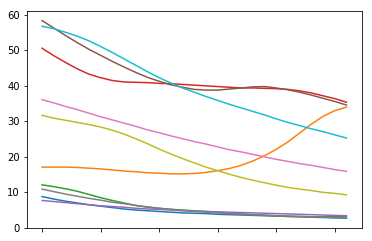

In [240]:
#Use the trend to replace missing values of child_mortality
mortality.iloc[:,1:-1].iloc[3].plot(); 
mortality.iloc[3,-1] = 2.6
mortality.iloc[:,1:-1].iloc[48].plot();
mortality.iloc[48,-1] = 35
mortality.iloc[:,1:-1].iloc[45].plot();
mortality.iloc[45,-1] = 3.2
mortality.iloc[:,1:-1].iloc[105].plot();
mortality.iloc[105,-1] = 34.4
mortality.iloc[:,1:-1].iloc[111].plot();
mortality.iloc[111,-1] = 3.3
mortality.iloc[:,1:-1].iloc[118].plot();
mortality.iloc[118,-1] = 33.6
mortality.iloc[:,1:-1].iloc[129].plot();
mortality.iloc[129,-1] = 14.6
mortality.iloc[:,1:-1].iloc[143].plot();
mortality.iloc[143,-1] = 2.7
mortality.iloc[:,1:-1].iloc[160].plot();
mortality.iloc[160,-1] = 8.9
mortality.iloc[:,1:-1].iloc[179].plot();
mortality.iloc[179,-1] = 24.4

Step 4: EDA and data cleaning (part 2)

/Users/chuwu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


Text(0.5,1,'Boxplot of Child Mortality in Different Years')

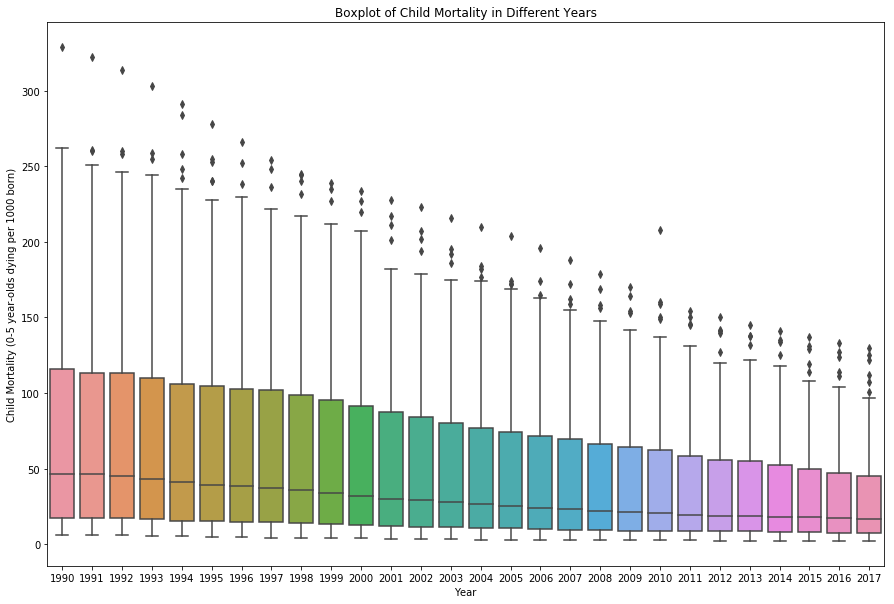

In [241]:
#Boxplot of mortality in different years

plt.figure(figsize=[15,10])
sns.boxplot(data=mortality .ix[:,1:30])
plt.xlabel('Year')
plt.ylabel('Child Mortality (0-5 year-olds dying per 1000 born)')
plt.title('Boxplot of Child Mortality in Different Years')


/Users/chuwu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


Text(0.5,1,'Boxplot of Death Rate in different years')

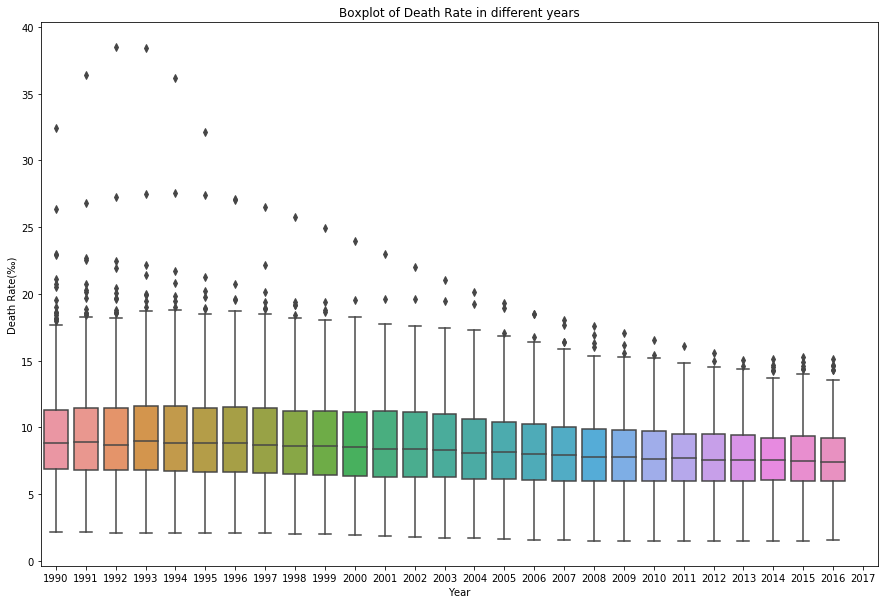

In [242]:
#Boxplot of death_rate in different years

plt.figure(figsize=[15,10])
sns.boxplot(data=death_rate .ix[:,1:30])
plt.xlabel('Year')
plt.ylabel('Death Rate(‰)')
plt.title('Boxplot of Death Rate in different years')

#we can use 2016 data to impute 2017 data

/Users/chuwu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


Text(0.5,1,'Boxplot of Birth Rate in Different Years')

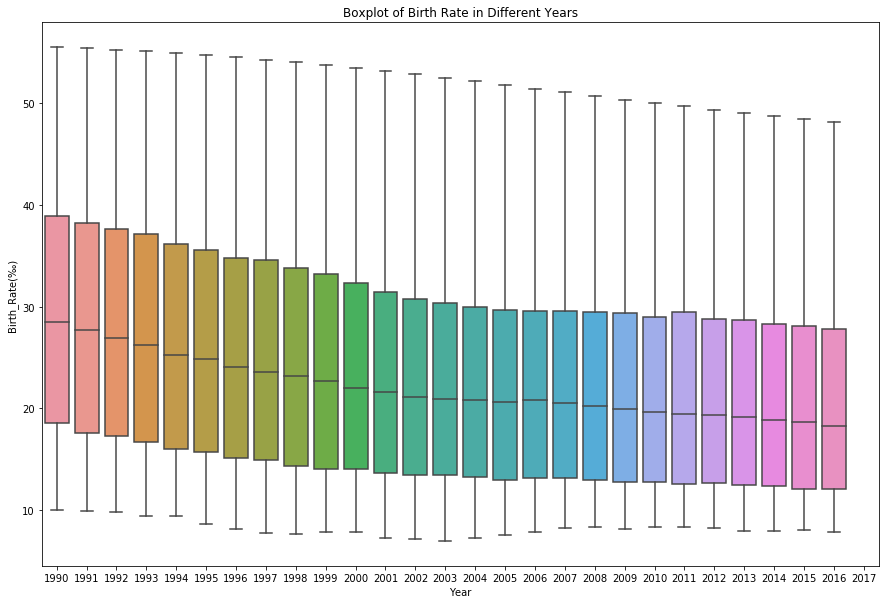

In [243]:
#Boxplot of birth_rate in different years

plt.figure(figsize=[15,10])
sns.boxplot(data=birth_rate .ix[:,1:30])
plt.xlabel('Year')
plt.ylabel('Birth_Rate(‰)')
plt.title('Boxplot of Birth Rate in Different Years')

#we should use a smaller value to impute 2017 data which satisfies the decending trend

/Users/chuwu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


Text(0.5,1,'Boxplot of Income in Different Years')

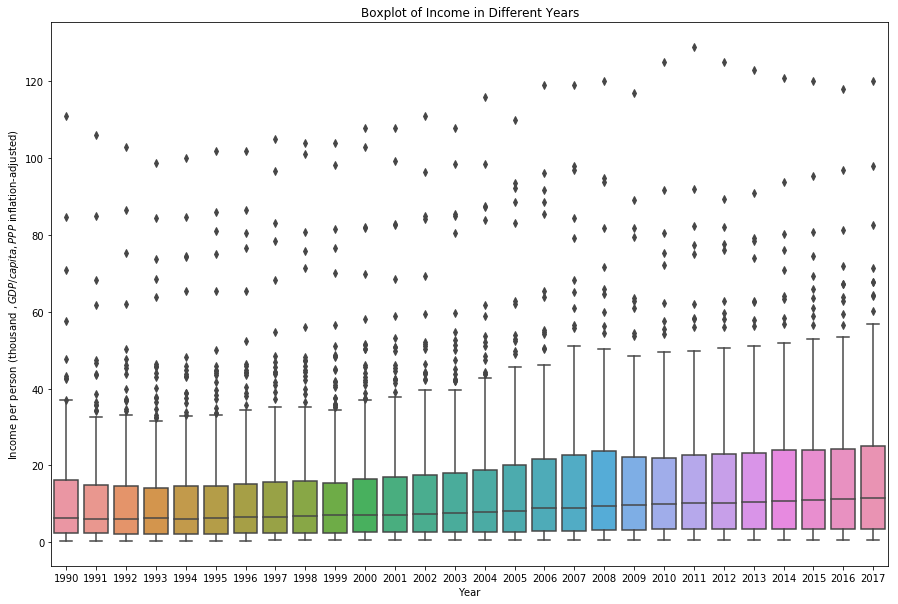

In [244]:
#Boxplot of income in different years

plt.figure(figsize=[15,10])
sns.boxplot(data=income .ix[:,1:30])
plt.xlabel('Year')
plt.ylabel('Income per person (thousand $, GDP/capita, PPP$ inflation-adjusted)')
plt.title('Boxplot of Income in Different Years')

/Users/chuwu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


Text(0.5,1,'Boxplot of GDP/capita in Different Years')

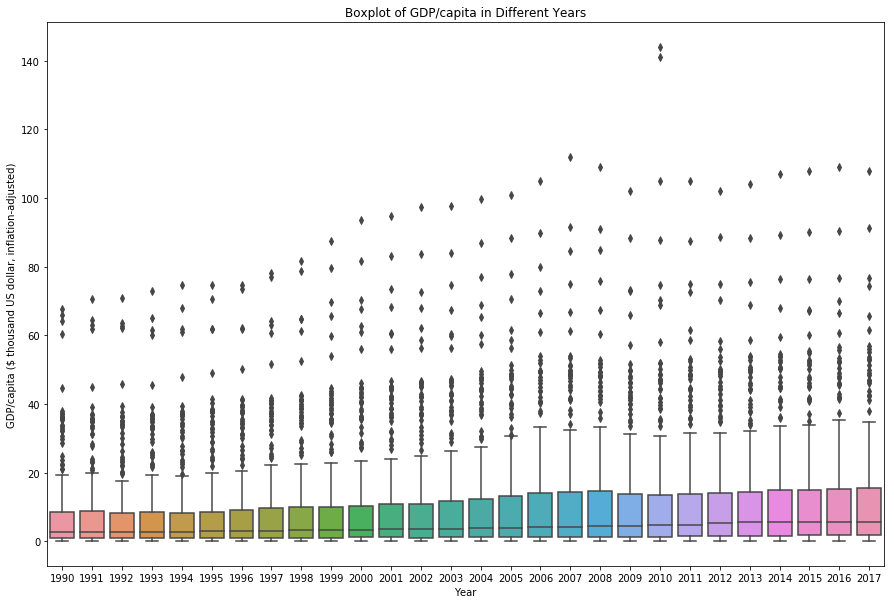

In [245]:
#Boxplot of gdp per capita in different years

plt.figure(figsize=[15,10])
sns.boxplot(data=gdp_cap .ix[:,1:30])
plt.xlabel('Year')
plt.ylabel('GDP/capita ($ thousand US dollar, inflation-adjusted)')
plt.title('Boxplot of GDP/capita in Different Years')

/Users/chuwu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


Text(0.5,1,'Boxplot of Population in Different Years')

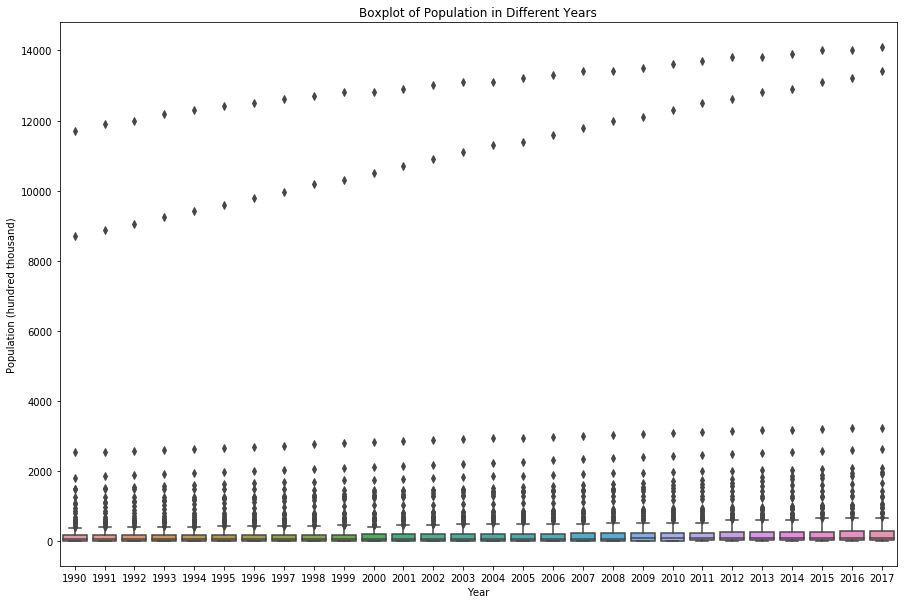

In [246]:
#Boxplot of population in different years

plt.figure(figsize=[15,10])
sns.boxplot(data=population .ix[:,1:30])
plt.xlabel('Year')
plt.ylabel('Population (hundred thousand)')
plt.title('Boxplot of Population in Different Years')
#China and India are outliers
#Similar as GDP (hundred million US$)

/Users/chuwu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


Text(0.5,1,'Boxplot of Population Growth Rate in Different Years')

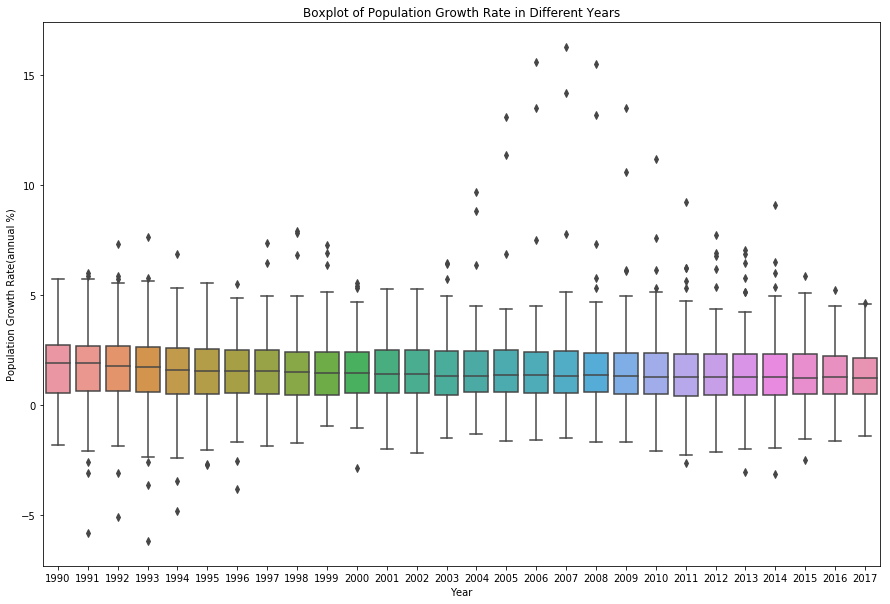

In [247]:
#Boxplot of population growth rate in different years

plt.figure(figsize=[15,10])
sns.boxplot(data=growth_rate .ix[:,1:30])
plt.xlabel('Year')
plt.ylabel('Population Growth Rate(annual %)')
plt.title('Boxplot of Population Growth Rate in Different Years')

Text(0.5,1,'Population Growth Rate by Country(annual %), 1990-2017')

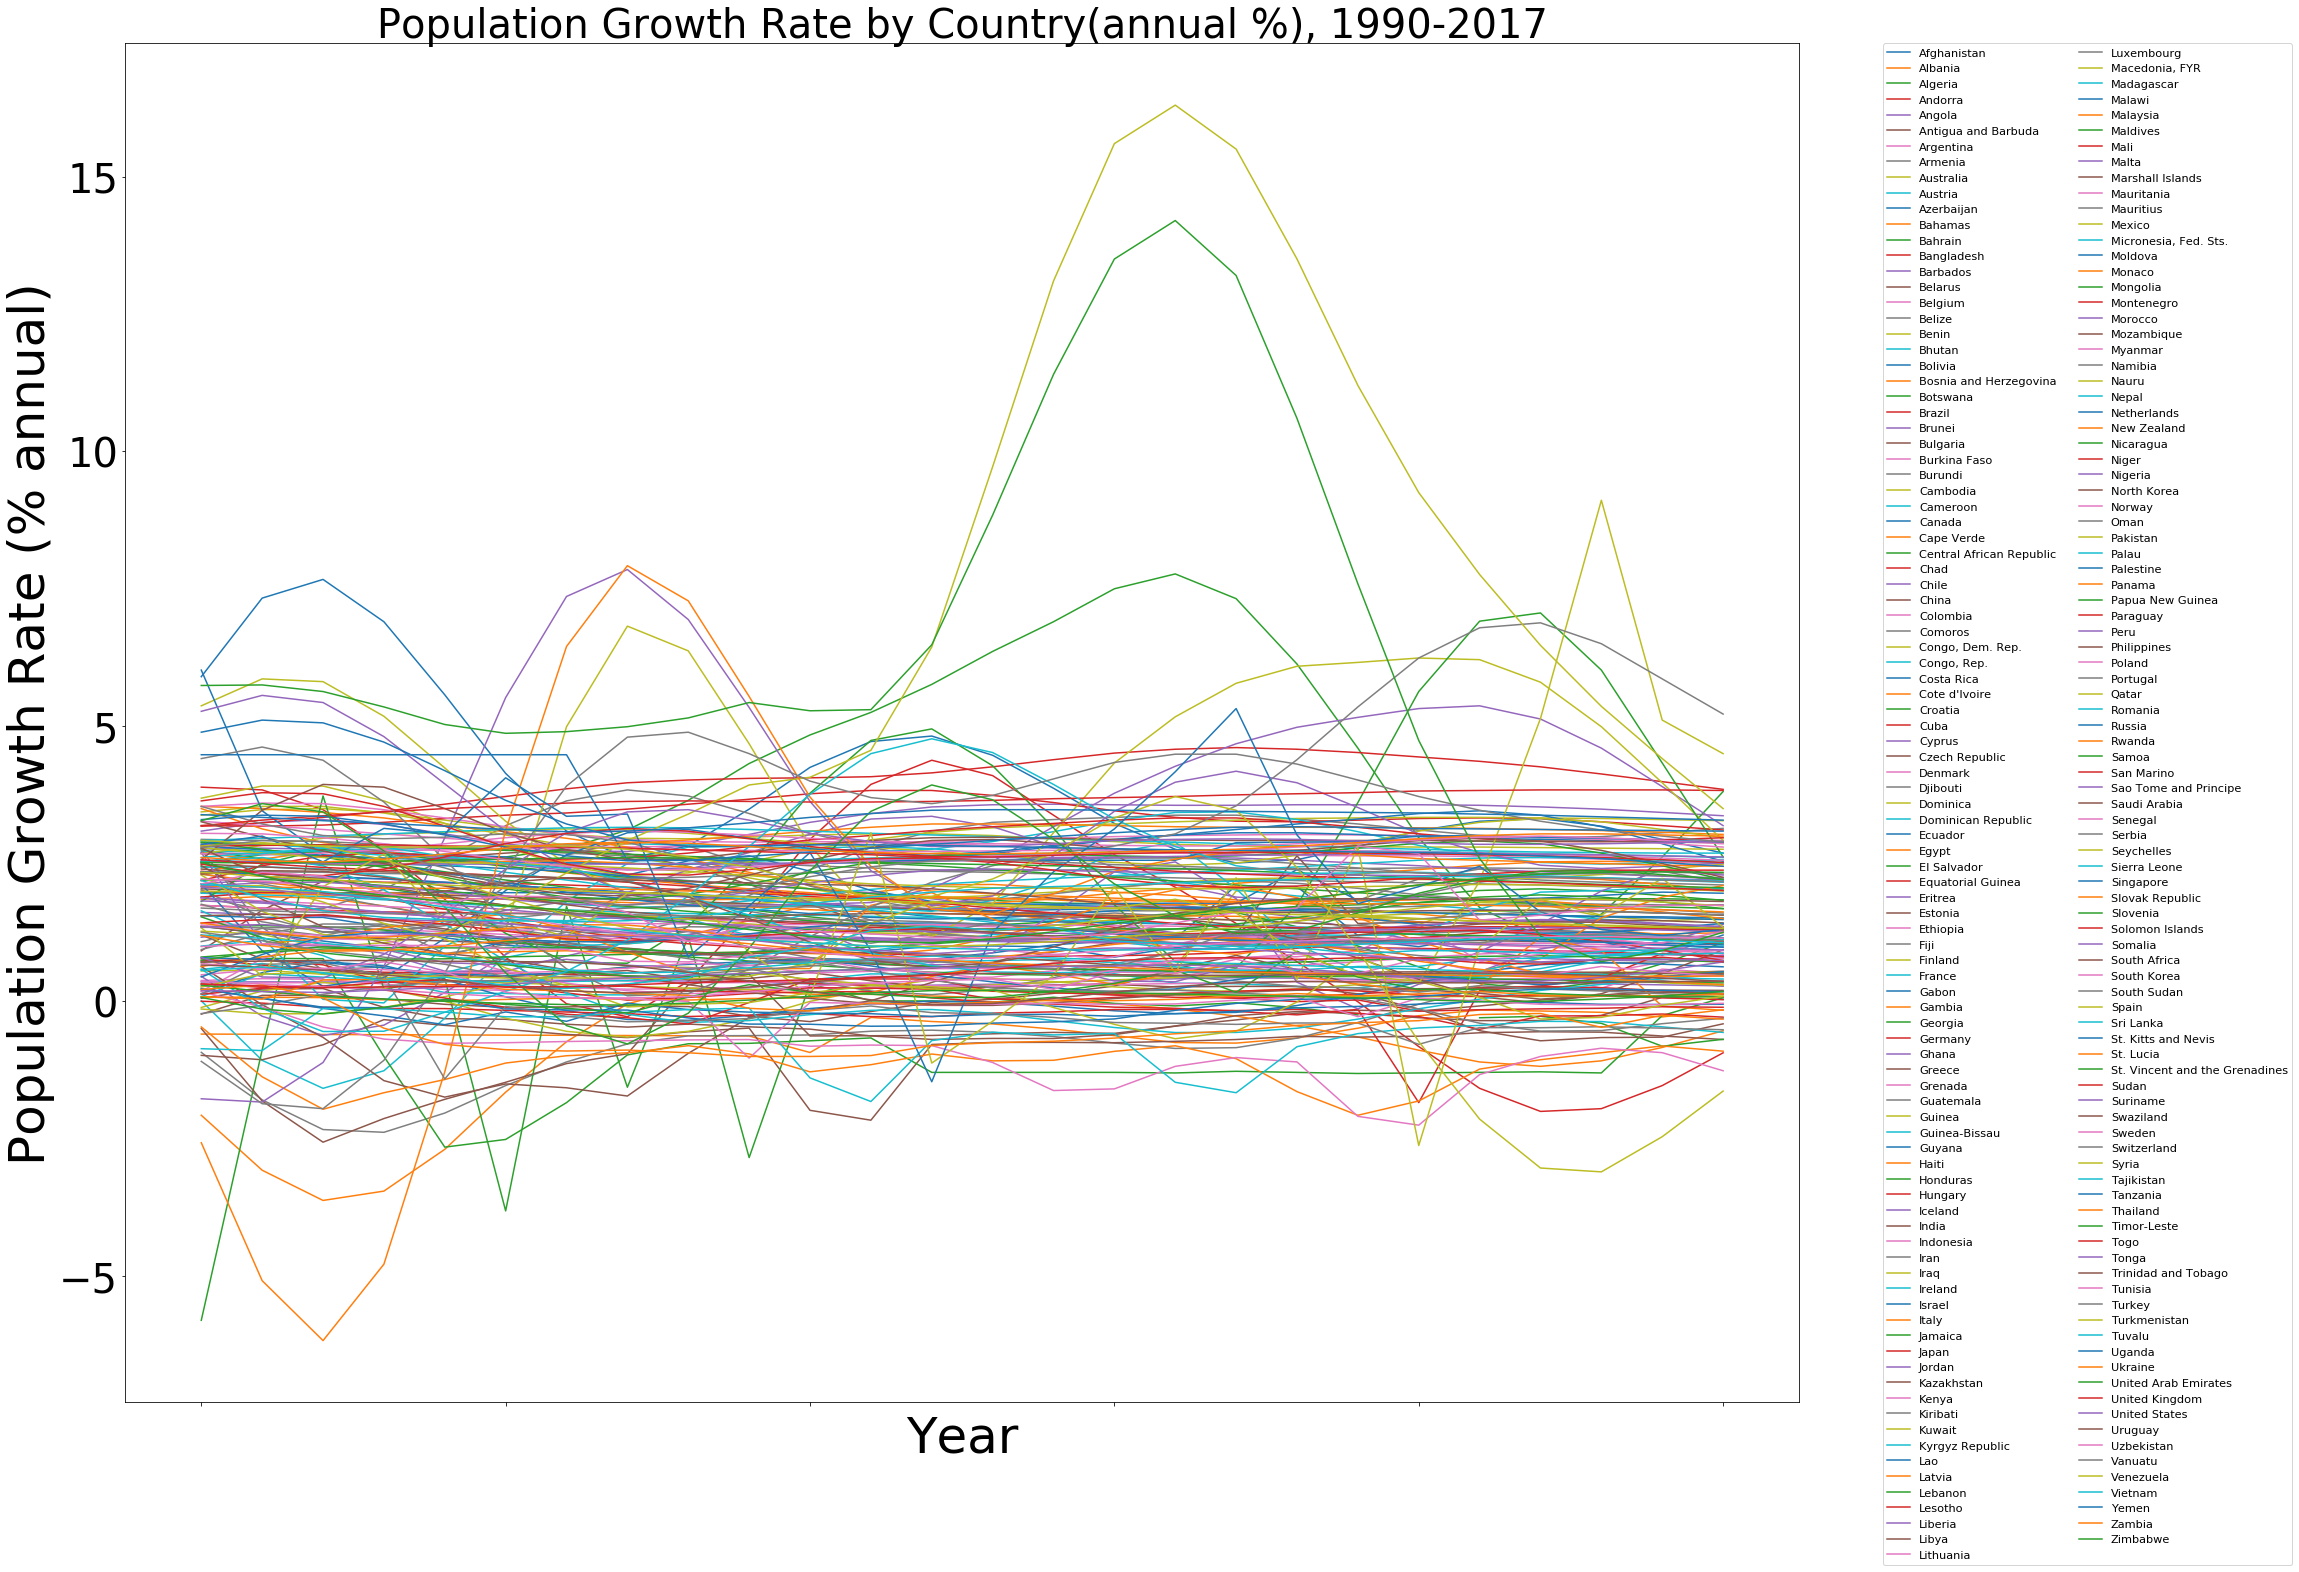

In [248]:
# Spaghetti Plot: Population Growth Rate by Country, 1990-2017

growth_rate_geoinx = growth_rate.set_index([growth_rate.columns[0]])
plt.figure(figsize=[30,25])
for i in range(len(growth_rate)):
    growth_rate_geoinx.iloc[:,1:-1].iloc[i].plot(fontsize =40)
plt.xlabel('Year',fontsize=50)
plt.ylabel('Population Growth Rate (% annual)',fontsize=50) 
plt.legend(loc=2,ncol =2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0., fontsize= 11.3)
plt.title('Population Growth Rate by Country(annual %), 1990-2017', fontsize=40)

In [249]:
#Rank of population growth rate in 2017
growth_rate_geoinx['2017'].nlargest(len(growth_rate))

geo
Oman                      4.6700
Bahrain                   4.6200
Nauru                     4.5000
Niger                     3.8200
Equatorial Guinea         3.7100
Angola                    3.3100
Uganda                    3.2600
Congo, Dem. Rep.          3.2500
Burundi                   3.1800
Tanzania                  3.0800
Chad                      3.0500
Gambia                    3.0000
Mali                      3.0000
Zambia                    2.9900
Luxembourg                2.9500
Somalia                   2.9200
Malawi                    2.8900
Burkina Faso              2.8900
Palestine                 2.8800
Mozambique                2.8700
Iraq                      2.8400
Senegal                   2.8100
South Sudan               2.7800
Benin                     2.7500
Mauritania                2.7300
Madagascar                2.6800
Qatar                     2.6700
Nigeria                   2.6000
Congo, Rep.               2.6000
Cameroon                  2.5900
      

In [250]:
#death_rate: use 2016 data to impute 2017 data
death_rate.iloc[:,-1] = death_rate.iloc[:,-2]

In [251]:
#birth_rate: impute 2017 data by shift down -0.2, determined by the trend of mean value
birth_rate.describe().mean()
birth_rate.iloc[:,-1] = birth_rate.iloc[:,-2]-0.2


Step 5: Merge dataset (half-cleaned)

In [252]:
"""Turns growth rate into panel data"""
growth_rate2 = growth_rate.iloc[:,[0,1]]
growth_rate2.columns = ['country','growth_rate']
year = list(growth_rate)[1]
growth_rate2.insert(1, 'year', year)
for i in range(1, len(growth_rate.columns)-1):
    year = list(growth_rate)[1+i]
    new_year = pd.DataFrame(growth_rate.iloc[:,0]).join(pd.DataFrame(growth_rate.iloc[:,i+1]))
    new_year.columns = ['country','growth_rate']
    new_year.insert(1, 'year', year)
    growth_rate2 = pd.concat([growth_rate2,new_year]).reset_index().drop('index', axis=1)

"""transforms birth_rate into panel data"""
birth_rate2 = birth_rate.iloc[:,[0,1]]
birth_rate2.columns = ['country','birth_rate']
year = list(birth_rate)[1]
birth_rate2.insert(1, 'year', year)
for i in range(1, len(birth_rate.columns)-1):
    year = list(birth_rate)[1+i]
    new_year = pd.DataFrame(birth_rate.iloc[:,0]).join(pd.DataFrame(birth_rate.iloc[:,i+1]))
    new_year.columns = ['country','birth_rate']
    new_year.insert(1, 'year', year)
    birth_rate2 = pd.concat([birth_rate2,new_year]).reset_index().drop('index', axis=1)
birth_rate2.year = birth_rate2.year.astype(str)   
    
    
"""transforms death_rate into panel data"""
death_rate2 = death_rate.iloc[:,[0,1]]
death_rate2.columns = ['country','death_rate']
year = list(death_rate)[1]
death_rate2.insert(1, 'year', year)
for i in range(1, len(death_rate.columns)-1):
    year = list(death_rate)[1+i]
    new_year = pd.DataFrame(death_rate.iloc[:,0]).join(pd.DataFrame(death_rate.iloc[:,i+1]))
    new_year.columns = ['country','death_rate']
    new_year.insert(1, 'year', year)
    death_rate2 = pd.concat([death_rate2,new_year]).reset_index().drop('index', axis=1)
death_rate2.year = death_rate2.year.astype(str)   
    
    
"""transforms child_mortality into panel data"""
child_mortality2 = mortality.iloc[:,[0,1]]
child_mortality2.columns = ['country','child_mortality']
year = list(mortality)[1]
child_mortality2.insert(1, 'year', year)
for i in range(1, len(mortality.columns)-1):
    year = list(mortality)[1+i]
    new_year = pd.DataFrame(mortality.iloc[:,0]).join(pd.DataFrame(mortality.iloc[:,i+1]))
    new_year.columns = ['country','child_mortality']
    new_year.insert(1, 'year', year)
    child_mortality2 = pd.concat([child_mortality2,new_year]).reset_index().drop('index', axis=1)
    
    
"""transforms gdp into panel data"""
gdp2 = gdp.iloc[:,[0,1]]
gdp2.columns = ['country','gdp']
year = list(gdp)[1]
gdp2.insert(1, 'year', year)
for i in range(1, len(gdp.columns)-1):
    year = list(gdp)[1+i]
    new_year = pd.DataFrame(gdp.iloc[:,0]).join(pd.DataFrame(gdp.iloc[:,i+1]))
    new_year.columns = ['country','gdp']
    new_year.insert(1, 'year', year)
    gdp2 = pd.concat([gdp2,new_year]).reset_index().drop('index', axis=1)

"""transforms gdp_cap into panel data"""
gdp_cap2 = gdp_cap.iloc[:,[0,1]]
gdp_cap2.columns = ['country','gdp_cap']
year = list(gdp_cap)[1]
gdp_cap2.insert(1, 'year', year)
for i in range(1, len(gdp_cap.columns)-1):
    year = list(gdp_cap)[1+i]
    new_year = pd.DataFrame(gdp_cap.iloc[:,0]).join(pd.DataFrame(gdp_cap.iloc[:,i+1]))
    new_year.columns = ['country','gdp_cap']
    new_year.insert(1, 'year', year)
    gdp_cap2 = pd.concat([gdp_cap2,new_year]).reset_index().drop('index', axis=1)
    

"""transforms income into panel data"""
income2 = income.iloc[:,[0,1]]
income2.columns = ['country','income']
year = list(income)[1]
income2.insert(1, 'year', year)
for i in range(1, len(income.columns)-1):
    year = list(income)[1+i]
    new_year = pd.DataFrame(income.iloc[:,0]).join(pd.DataFrame(income.iloc[:,i+1]))
    new_year.columns = ['country','income']
    new_year.insert(1, 'year', year)
    income2 = pd.concat([income2,new_year]).reset_index().drop('index', axis=1)


"""transforms population into panel data"""
population2 = population.iloc[:,[0,1]]
population2.columns = ['country','population']
year = list(population)[1]
population2.insert(1, 'year', year)
for i in range(1, len(population.columns)-1):
    year = list(population)[1+i]
    new_year = pd.DataFrame(population.iloc[:,0]).join(pd.DataFrame(population.iloc[:,i+1]))
    new_year.columns = ['country','population']
    new_year.insert(1, 'year', year)
    population2 = pd.concat([population2,new_year]).reset_index().drop('index', axis=1) 

continents = pd.read_csv('/Users/chuwu/Desktop/project1/datasets/continents.csv')

    
"""aggregate datatables"""
final_data = pd.merge(growth_rate2, population2, how='left', on=['country', 'year'])
final_data = pd.merge(final_data, birth_rate2, how='left', on=['country', 'year'])
final_data = pd.merge(final_data, death_rate2, how='left', on=['country', 'year'])
final_data = pd.merge(final_data, gdp2, how='left', on=['country', 'year'])
final_data = pd.merge(final_data, gdp_cap2, how='left', on=['country', 'year'])
final_data = pd.merge(final_data, child_mortality2, how='left', on=['country', 'year'])
final_data = pd.merge(final_data, income2, how='left', on=['country', 'year'])
final_data = pd.merge(final_data, continents, how='left')
final_data = final_data.sort_values(["country","year"])
final_data

,country,year,growth_rate,population,birth_rate,death_rate,gdp,gdp_cap,child_mortality,income,continent
0,Afghanistan,1990,3.930,122.0,49.080,15.577,NaN,NaN,177.0,1.040,Asia
193,Afghanistan,1991,5.900,130.0,48.945,15.036,NaN,NaN,171.0,1.030,Asia
386,Afghanistan,1992,7.330,140.0,48.879,14.562,NaN,NaN,165.0,0.950,Asia
579,Afghanistan,1993,7.670,151.0,48.882,14.152,NaN,NaN,160.0,0.818,Asia
772,Afghanistan,1994,6.900,162.0,48.937,13.799,NaN,NaN,155.0,0.732,Asia
965,Afghanistan,1995,5.570,171.0,49.014,13.489,NaN,NaN,150.0,0.881,Asia
1158,Afghanistan,1996,4.140,178.0,49.072,13.204,NaN,NaN,145.0,0.904,Asia
1351,Afghanistan,1997,3.090,184.0,49.067,12.923,NaN,NaN,141.0,0.930,Asia
1544,Afghanistan,1998,2.590,189.0,48.960,12.628,NaN,NaN,137.0,0.956,Asia
1737,Afghanistan,1999,2.820,194.0,48.728,12.310,NaN,NaN,133.0,0.982,Asia


In [253]:
final_data.shape

(5404, 11)

In [254]:
#select_out countries with way too many missing data
final_A = final_data.copy()
final_A['count_missing'] = final_A.shape[1] - final_A.count(axis=1)
country_drop = final_A.groupby(['country']).count_missing.sum().sort_values(ascending=False)
country_drop.nlargest(75)
# keep Montenegro and below for our final dataset. Move the rest to an additional dataset.

country
North Korea               140
Syria                     140
Monaco                    102
Palestine                  93
Nauru                      90
Venezuela                  90
Brunei                     84
Swaziland                  84
Russia                     84
Cape Verde                 84
Iran                       84
South Korea                84
Lao                        84
St. Kitts and Nevis        72
Yemen                      58
South Sudan                56
Tuvalu                     56
Bahamas                    56
Somalia                    56
Gambia                     56
Egypt                      56
Djibouti                   54
Marshall Islands           47
San Marino                 42
Moldova                    38
Dominica                   36
Slovak Republic            32
Tanzania                   28
Czech Republic             28
Cote d'Ivoire              28
                         ... 
Qatar                      20
Palau                      20
Ti

In [255]:
country_drop.describe()
#After looking at the actual data of selected countries, let's seperate out around 25% of countries, keep Montenegro

count    193.000000
mean      13.818653
std       27.119206
min        0.000000
25%        0.000000
50%        0.000000
75%       18.000000
max      140.000000
Name: count_missing, dtype: float64

In [256]:
Montenegro = final_data.loc[final_data['country'] == 'Montenegro']
Montenegro

,country,year,growth_rate,population,birth_rate,death_rate,gdp,gdp_cap,child_mortality,income,continent
113,Montenegro,1990,-0.0328,6.15,16.487,7.159,NaN,NaN,16.60,16.50,Europe
306,Montenegro,1991,0.1210,6.16,16.182,7.277,NaN,NaN,15.90,14.60,Europe
499,Montenegro,1992,0.2320,6.17,15.864,7.458,NaN,NaN,15.50,11.10,Europe
692,Montenegro,1993,0.2710,6.19,15.532,7.706,NaN,NaN,15.30,6.94,Europe
885,Montenegro,1994,0.2000,6.20,15.193,8.013,NaN,NaN,15.20,6.94,Europe
1078,Montenegro,1995,0.0528,6.20,14.860,8.358,NaN,NaN,15.20,7.81,Europe
1271,Montenegro,1996,-0.1160,6.20,14.547,8.713,NaN,NaN,15.10,9.78,Europe
1464,Montenegro,1997,-0.2430,6.18,14.267,9.048,30.6,5.01,15.00,10.20,Europe
1657,Montenegro,1998,-0.3050,6.16,14.029,9.337,32.1,5.28,14.90,10.70,Europe
1850,Montenegro,1999,-0.4190,6.15,13.835,9.570,29.0,4.79,14.60,9.76,Europe


In [257]:
country_drop.nlargest(51).index

Index(['North Korea', 'Syria', 'Monaco', 'Palestine', 'Nauru', 'Venezuela',
       'Brunei', 'Swaziland', 'Russia', 'Cape Verde', 'Iran', 'South Korea',
       'Lao', 'St. Kitts and Nevis', 'Yemen', 'South Sudan', 'Tuvalu',
       'Bahamas', 'Somalia', 'Gambia', 'Egypt', 'Djibouti', 'Marshall Islands',
       'San Marino', 'Moldova', 'Dominica', 'Slovak Republic', 'Tanzania',
       'Czech Republic', 'Cote d'Ivoire', 'St. Vincent and the Grenadines',
       'St. Lucia', 'Congo, Rep.', 'Congo, Dem. Rep.', 'United Kingdom',
       'United States', 'Bolivia', 'Kyrgyz Republic', 'Macedonia, FYR',
       'Vietnam', 'Micronesia, Fed. Sts.', 'Afghanistan', 'Andorra',
       'Sao Tome and Principe', 'Eritrea', 'Qatar', 'Palau', 'Timor-Leste',
       'Serbia', 'Libya', 'Montenegro'],
      dtype='object', name='country')

In [258]:
final_A = final_data[final_data['country'].isin(['North Korea', 'Syria', 'Monaco', 'Palestine', 'Nauru', 'Venezuela',
       'Iran', 'Brunei', 'South Korea', 'Cape Verde', 'Russia', 'Lao',
       'Swaziland', 'St. Kitts and Nevis', 'Yemen', 'Tuvalu', 'Gambia',
       'Egypt', 'South Sudan', 'Somalia', 'Bahamas', 'Djibouti',
       'Marshall Islands', 'San Marino', 'Moldova', 'Dominica',
       'Slovak Republic', 'Czech Republic', 'Kyrgyz Republic',
       'Macedonia, FYR', 'Tanzania', 'Micronesia, Fed. Sts.', 'St. Lucia',
       'St. Vincent and the Grenadines', "Cote d'Ivoire", 'Congo, Rep.',
       'Congo, Dem. Rep.', 'United Kingdom', 'United States', 'Bolivia',
       'Vietnam', 'Afghanistan', 'Eritrea', 'Andorra', 'Sao Tome and Principe',
       'Palau', 'Qatar', 'Timor-Leste', 'Serbia', 'Libya'])]
final_A.head()


,country,year,growth_rate,population,birth_rate,death_rate,gdp,gdp_cap,child_mortality,income,continent
0,Afghanistan,1990,3.93,122.0,49.080,15.577,NaN,NaN,177.0,1.040,Asia
193,Afghanistan,1991,5.90,130.0,48.945,15.036,NaN,NaN,171.0,1.030,Asia
386,Afghanistan,1992,7.33,140.0,48.879,14.562,NaN,NaN,165.0,0.950,Asia
579,Afghanistan,1993,7.67,151.0,48.882,14.152,NaN,NaN,160.0,0.818,Asia
772,Afghanistan,1994,6.90,162.0,48.937,13.799,NaN,NaN,155.0,0.732,Asia


In [259]:
final_B = final_data[~final_data['country'].isin(['North Korea', 'Syria', 'Monaco', 'Palestine', 'Nauru', 'Venezuela',
       'Iran', 'Brunei', 'South Korea', 'Cape Verde', 'Russia', 'Lao',
       'Swaziland', 'St. Kitts and Nevis', 'Yemen', 'Tuvalu', 'Gambia',
       'Egypt', 'South Sudan', 'Somalia', 'Bahamas', 'Djibouti',
       'Marshall Islands', 'San Marino', 'Moldova', 'Dominica',
       'Slovak Republic', 'Czech Republic', 'Kyrgyz Republic',
       'Macedonia, FYR', 'Tanzania', 'Micronesia, Fed. Sts.', 'St. Lucia',
       'St. Vincent and the Grenadines', "Cote d'Ivoire", 'Congo, Rep.',
       'Congo, Dem. Rep.', 'United Kingdom', 'United States', 'Bolivia',
       'Vietnam', 'Afghanistan', 'Eritrea', 'Andorra', 'Sao Tome and Principe',
       'Palau', 'Qatar', 'Timor-Leste', 'Serbia', 'Libya'])]
final_B
#143 countries left

,country,year,growth_rate,population,birth_rate,death_rate,gdp,gdp_cap,child_mortality,income,continent
1,Albania,1990,1.800,32.8,24.789,5.989,64.0,1.950,40.0,4.56,Europe
194,Albania,1991,-0.603,32.8,24.171,6.078,45.1,1.380,38.3,3.23,Europe
387,Albania,1992,-0.606,32.4,23.460,6.160,41.8,1.290,36.9,3.01,Europe
580,Albania,1993,-0.610,31.9,22.680,6.223,45.8,1.420,35.5,3.32,Europe
773,Albania,1994,-0.614,31.4,21.845,6.258,49.7,1.550,34.2,3.62,Europe
966,Albania,1995,-0.618,31.1,20.970,6.258,56.3,1.760,32.9,4.13,Europe
1159,Albania,1996,-0.622,30.9,20.064,6.222,61.4,1.940,31.5,4.53,Europe
1352,Albania,1997,-0.625,30.9,19.139,6.157,54.7,1.740,30.1,4.07,Europe
1545,Albania,1998,-0.629,31.0,18.212,6.077,59.7,1.910,28.7,4.46,Europe
1738,Albania,1999,-0.633,31.2,17.303,5.993,67.7,2.180,27.4,5.10,Europe


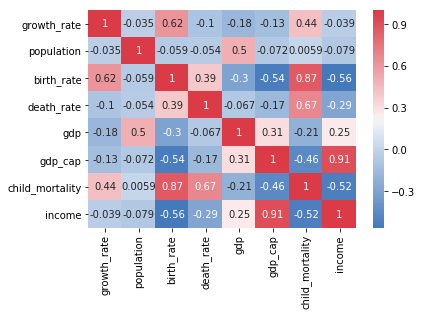

In [260]:
corr = final_B.loc[:,final_B.dtypes == 'float64'].corr()
sns.heatmap(corr, annot = True, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(250, 10, as_cmap=True))

Since the idea of gdp per capita is very similar to income, and they are highly correlated, we could drop gdp_cap. That helps to avoid missing values as well.

In [261]:
#drop gdp_cap
final_B = final_B.drop(columns=['gdp_cap'])


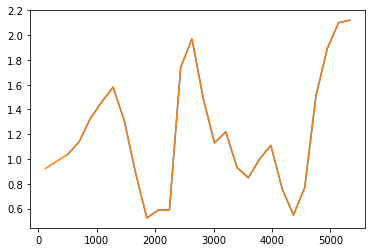

In [262]:
#impute missing value for New Zeland

New_zealand = final_B.loc[final_data['country'] == 'New Zealand']
New_zealand;
New_zealand.growth_rate.plot()
final_B.iloc[2689] = final_B.iloc[2689].fillna(0.9815)
final_B.iloc[2689]
New_zealand = final_B.loc[final_data['country'] == 'New Zealand']
New_zealand.growth_rate.plot()

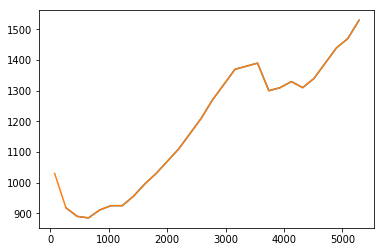

In [263]:
Hungary = final_B.loc[final_data['country'] == 'Hungary']
Hungary;
Hungary.gdp.plot()
#impute missing value for Hungary
final_B.iloc[1624] = final_B.iloc[1624].fillna(1030.0)
Hungary = final_B.loc[final_data['country'] == 'Hungary']
Hungary.gdp.plot()

In [264]:
Cuba = final_B.loc[final_data['country'] == 'Cuba']
Cuba
#impute missing value for Cuba
final_B.iloc[978] = final_B.iloc[978].fillna(739*(1+0.005))
final_B.iloc[979] = final_B.iloc[979].fillna(739*(1+0.005)*(1+0.016))


In [265]:
Cambodia = final_B.loc[final_data['country'] == 'Cambodia']
Cambodia
#impute missing value for Cambodia
final_B.iloc[644] = final_B.iloc[644].fillna(30.0)
final_B.iloc[645] = final_B.iloc[645].fillna(33.1)
final_B.iloc[646] = final_B.iloc[646].fillna(36.5)


In [266]:
Bosnia = final_B.loc[final_data['country'] == 'Bosnia and Herzegovina']
Bosnia
#impute missing value for Cambodia
final_B.iloc[476] = final_B.iloc[476].fillna(4.8)
final_B.iloc[477] = final_B.iloc[477].fillna(10.5)
final_B.iloc[478] = final_B.iloc[478].fillna(16.2)
final_B.iloc[479] = final_B.iloc[479].fillna(21.9)

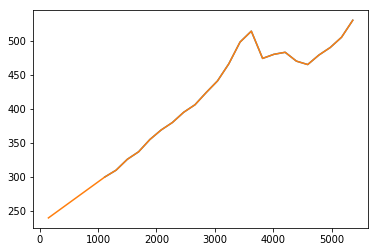

In [267]:
Slovenia = final_B.loc[final_data['country'] == 'Slovenia']
Slovenia
Slovenia.gdp.plot()
#impute missing value for Slovenia
final_B.iloc[3304] = final_B.iloc[3304].fillna(240)
final_B.iloc[3305] = final_B.iloc[3305].fillna(252)
final_B.iloc[3306] = final_B.iloc[3306].fillna(264)
final_B.iloc[3307] = final_B.iloc[3307].fillna(276)
final_B.iloc[3308] = final_B.iloc[3308].fillna(288)
Slovenia = final_B.loc[final_data['country'] == 'Slovenia']
Slovenia.gdp.plot()

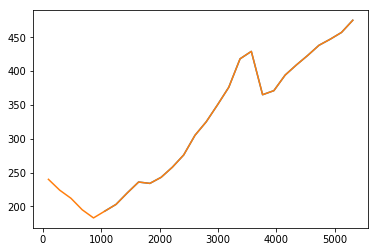

In [268]:
Lithuania = final_B.loc[final_data['country'] == 'Lithuania']
Lithuania
Lithuania.gdp.plot()
#impute missing value for Lithuania
final_B.iloc[2156] = final_B.iloc[2156].fillna(240.0)
final_B.iloc[2157] = final_B.iloc[2157].fillna(224.0)
final_B.iloc[2158] = final_B.iloc[2158].fillna(212.0)
final_B.iloc[2159] = final_B.iloc[2159].fillna(195.0)
final_B.iloc[2160] = final_B.iloc[2160].fillna(183.0)
Lithuania = final_B.loc[final_data['country'] == 'Lithuania']
Lithuania.gdp.plot()

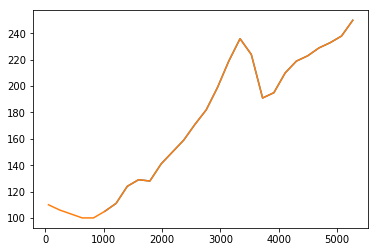

In [269]:
Estonia = final_B.loc[final_data['country'] == 'Estonia']
Estonia
Estonia.gdp.plot()
#impute missing value for Estonia
final_B.iloc[1148] = final_B.iloc[1148].fillna(110.0)
final_B.iloc[1149] = final_B.iloc[1149].fillna(106.0)
final_B.iloc[1150] = final_B.iloc[1150].fillna(103.0)
final_B.iloc[1151] = final_B.iloc[1151].fillna(100.0)
final_B.iloc[1152] = final_B.iloc[1152].fillna(100.0)
Estonia = final_B.loc[final_data['country'] == 'Estonia']
Estonia.gdp.plot()

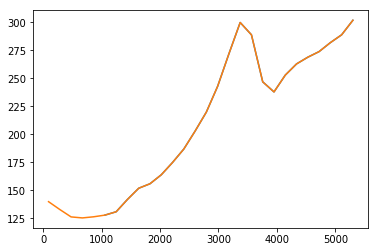

In [270]:
Latvia = final_B.loc[final_data['country'] == 'Latvia']
Latvia
Latvia.gdp.plot()
#impute missing value for Latvia
final_B.iloc[2044] = final_B.iloc[2044].fillna(140.0)
final_B.iloc[2045] = final_B.iloc[2045].fillna(133.0)
final_B.iloc[2046] = final_B.iloc[2046].fillna(126.4)
final_B.iloc[2047] = final_B.iloc[2047].fillna(125.5)
final_B.iloc[2048] = final_B.iloc[2048].fillna(126.5)
Latvia = final_B.loc[final_data['country'] == 'Latvia']
Latvia.gdp.plot()

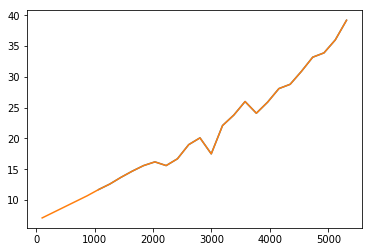

In [271]:
Maldives = final_B.loc[final_data['country'] == 'Maldives']
Maldives
Maldives.gdp.plot()
#impute missing value for Maldives
final_B.iloc[2296] = final_B.iloc[2296].fillna(7.1)
final_B.iloc[2297] = final_B.iloc[2297].fillna(8)
final_B.iloc[2298] = final_B.iloc[2298].fillna(8.9)
final_B.iloc[2299] = final_B.iloc[2299].fillna(9.8)
final_B.iloc[2300] = final_B.iloc[2300].fillna(10.7)
Maldives = final_B.loc[final_data['country'] == 'Maldives']
Maldives
Maldives.gdp.plot()

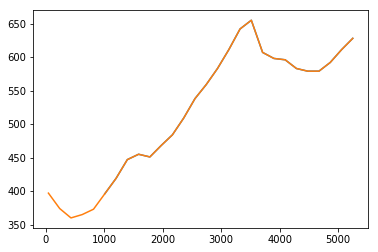

In [272]:
Croatia = final_B.loc[final_data['country'] == 'Croatia']
Croatia
Croatia.gdp.plot()
#impute missing value for Maldives
final_B.iloc[924] = final_B.iloc[924].fillna(397.0)
final_B.iloc[925] = final_B.iloc[925].fillna(374.0)
final_B.iloc[926] = final_B.iloc[926].fillna(360.0)
final_B.iloc[927] = final_B.iloc[927].fillna(365.0)
final_B.iloc[928] = final_B.iloc[928].fillna(373.0)
Croatia = final_B.loc[final_data['country'] == 'Croatia']
Croatia
Croatia.gdp.plot()

In [273]:
final_B.iloc[945] = final_B.iloc[945].fillna(-0.2805)

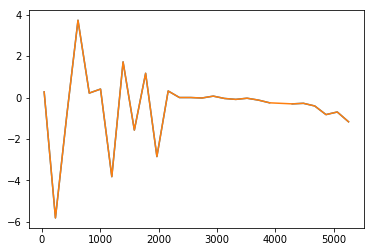

In [274]:
Croatia.growth_rate.plot()
final_B.iloc[945] = final_B.iloc[945].fillna(-0.2805)
Croatia = final_B.loc[final_data['country'] == 'Croatia']
Croatia.growth_rate.plot()

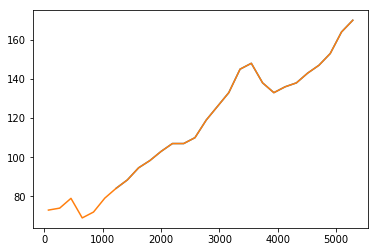

In [275]:
Iceland = final_B.loc[final_data['country'] == 'Iceland']
Iceland
Iceland.gdp.plot()
#impute missing value for Iceland
final_B.iloc[1652] = final_B.iloc[1652].fillna(73.0)
final_B.iloc[1653] = final_B.iloc[1653].fillna(74.0)
final_B.iloc[1654] = final_B.iloc[1654].fillna(79.0)
final_B.iloc[1655] = final_B.iloc[1655].fillna(69.0)
final_B.iloc[1656] = final_B.iloc[1656].fillna(72.0)
final_B.iloc[1657] = final_B.iloc[1657].fillna(79.1)
Iceland = final_B.loc[final_data['country'] == 'Iceland']
Iceland.gdp.plot()

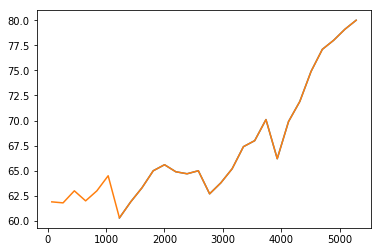

In [276]:
Haiti = final_B.loc[final_data['country'] == 'Haiti']
Haiti
Haiti.gdp.plot()
#impute missing value for Haidi
final_B.iloc[1568] = final_B.iloc[1568].fillna(61.9)
final_B.iloc[1569] = final_B.iloc[1569].fillna(61.8)
final_B.iloc[1570] = final_B.iloc[1570].fillna(63.0)
final_B.iloc[1571] = final_B.iloc[1571].fillna(62.0)
final_B.iloc[1572] = final_B.iloc[1572].fillna(63.0)
final_B.iloc[1573] = final_B.iloc[1573].fillna(64.5)
Haiti = final_B.loc[final_data['country'] == 'Haiti']
Haiti.gdp.plot()

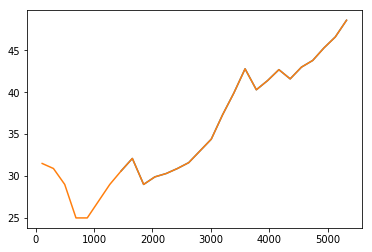

In [277]:
Montenegro = final_B.loc[final_data['country'] == 'Montenegro']
Montenegro
Montenegro.gdp.plot()
#impute missing value for Montenegro
final_B.iloc[2492] = final_B.iloc[2492].fillna(31.5)
final_B.iloc[2493] = final_B.iloc[2493].fillna(30.9)
final_B.iloc[2494] = final_B.iloc[2494].fillna(29.0)
final_B.iloc[2495] = final_B.iloc[2495].fillna(25.0)
final_B.iloc[2496] = final_B.iloc[2496].fillna(25.0)
final_B.iloc[2497] = final_B.iloc[2497].fillna(27.0)
final_B.iloc[2498] = final_B.iloc[2498].fillna(29.0)
Montenegro = final_B.loc[final_data['country'] == 'Montenegro']
Montenegro.gdp.plot()

In [279]:
final_B = final_B[~final_B['country'].isin(['Kuwait'])]
final_B.describe()
#Kuwait miss several population growth rate data  , seperate Kuwait from final B'

,growth_rate,population,birth_rate,death_rate,gdp,child_mortality,income
count,3976.000000,3976.000000,3976.000000,3976.000000,3976.000000,3976.000000,3976.000000
mean,1.503092,373.758613,24.047239,9.005954,2552.401847,50.981932,14.471780
std,1.420748,1456.027187,11.687261,3.860941,7556.500216,55.653192,16.315398
min,-6.180000,0.667000,7.600000,1.473000,1.220000,2.080000,0.247000
25%,0.521000,26.275000,13.391500,6.300000,61.800000,10.200000,2.680000
50%,1.410000,80.700000,21.824500,8.200000,226.000000,27.300000,8.410000
75%,2.490000,219.000000,33.522500,10.626250,1592.500000,76.400000,20.000000
max,14.200000,14100.000000,55.565000,38.492000,102000.000000,329.000000,111.000000


In [ ]:
final_B.to_csv('/Users/chuwu/Desktop/project1/final_final.csv', index = False)

In [280]:
final_data = final_B

Step 6: EDA

In [281]:
final_B.nlargest(20,"growth_rate")

,country,year,growth_rate,population,birth_rate,death_rate,gdp,child_mortality,income,continent
3463,United Arab Emirates,2007,14.20,60.40,13.000,1.540,2920.00,9.3,79.300,Asia
3270,United Arab Emirates,2006,13.50,52.40,13.507,1.581,2830.00,9.6,88.600,Asia
3656,United Arab Emirates,2008,13.20,68.90,12.521,1.508,3010.00,9.1,71.700,Asia
3077,United Arab Emirates,2005,11.40,45.80,14.024,1.629,2570.00,9.8,92.300,Asia
3849,United Arab Emirates,2009,10.60,76.70,12.073,1.485,2850.00,8.8,61.100,Asia
2884,United Arab Emirates,2004,8.84,40.90,14.533,1.682,2450.00,10.1,98.600,Asia
1685,Rwanda,1998,7.92,70.60,41.330,18.140,23.20,240.0,0.790,Africa
1638,Liberia,1998,7.85,25.50,43.335,14.615,7.23,208.0,0.606,Africa
3293,Bahrain,2007,7.77,10.40,17.684,2.388,226.00,9.8,43.300,Asia
4042,United Arab Emirates,2010,7.59,82.70,11.656,1.474,2900.00,8.6,57.600,Asia


In [282]:
final_data.nsmallest(20,"growth_rate")

,country,year,growth_rate,population,birth_rate,death_rate,gdp,child_mortality,income,continent
720,Rwanda,1993,-6.18,63.000,44.596,38.426,24.7,184.0,0.942,Africa
235,Croatia,1991,-5.81,47.600,11.100,11.700,374.0,12.1,14.100,Europe
527,Rwanda,1992,-5.09,67.000,45.412,38.492,26.9,166.0,0.964,Africa
913,Rwanda,1994,-4.79,60.100,43.857,36.149,12.3,284.0,0.492,Africa
1200,Croatia,1996,-3.82,45.700,11.800,11.100,419.0,9.6,13.900,Europe
600,Bosnia and Herzegovina,1993,-3.63,40.900,13.725,8.449,21.9,17.6,1.370,Europe
793,Bosnia and Herzegovina,1994,-3.46,39.500,13.453,8.533,27.6,14.8,1.470,Europe
407,Bosnia and Herzegovina,1992,-3.08,42.400,14.044,8.277,16.2,18.1,1.840,Europe
1972,Croatia,2000,-2.85,44.300,9.800,11.200,468.0,8.3,15.700,Europe
986,Bosnia and Herzegovina,1995,-2.70,38.400,13.195,8.533,33.3,14.2,1.830,Europe


In [283]:
final_data.nlargest(1000,"child_mortality")[final_data.year>='1990']

/Users/chuwu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,country,year,growth_rate,population,birth_rate,death_rate,gdp,child_mortality,income,continent
123,Niger,1990,3.090,80.100,55.565,22.987,30.60,329.0,0.894,Africa
316,Niger,1991,3.190,82.700,55.433,22.500,31.40,322.0,0.888,Africa
509,Niger,1992,3.290,85.500,55.296,21.963,29.40,314.0,0.803,Africa
702,Niger,1993,3.370,88.400,55.142,21.390,29.80,303.0,0.788,Africa
895,Niger,1994,3.440,91.500,54.967,20.790,31.00,291.0,0.792,Africa
913,Rwanda,1994,-4.790,60.100,43.857,36.149,12.30,284.0,0.492,Africa
1088,Niger,1995,3.500,94.800,54.768,20.178,31.80,278.0,0.784,Africa
1281,Niger,1996,3.550,98.200,54.546,19.566,32.90,266.0,0.783,Africa
149,Sierra Leone,1990,1.470,43.100,46.826,26.331,17.90,262.0,1.250,Africa
342,Sierra Leone,1991,0.578,43.400,46.779,26.836,18.40,261.0,1.270,Africa


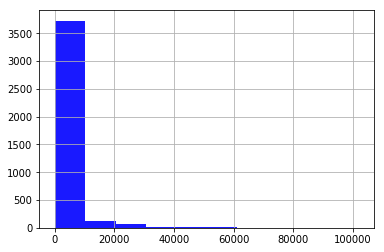

In [284]:
#plt.hist(new_dataset['growth_rate'], bins=30, density=True, alpha=0.8, histtype='stepfilled', color='steelblue')
#plt.hist(final_data['gdp'], bins=30, density=True, alpha=0.8, histtype='stepfilled', color='steelblue')
#Nan value will destroy plt.hist. The code below works.
final_data['gdp'].hist(alpha=0.9, color='blue')
#some countries have very high gdp

In [285]:
final_data.nlargest(1000,"gdp")[final_data.year>='2016']

/Users/chuwu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,country,year,growth_rate,population,birth_rate,death_rate,gdp,child_mortality,income,continent
5246,China,2017,0.5590,14100.0,11.800,7.300,102000.0,10.20,15.20,Asia
5053,China,2016,0.5410,14000.0,12.000,7.300,95100.0,9.90,14.40,Asia
5294,Japan,2017,-0.1640,1270.0,7.600,10.500,61600.0,2.83,38.60,Asia
5101,Japan,2016,-0.1150,1280.0,7.800,10.500,60500.0,2.70,38.20,Asia
5274,Germany,2017,0.4200,821.0,9.100,11.200,38700.0,3.29,44.60,Europe
5081,Germany,2016,0.8070,819.0,9.300,11.200,37800.0,3.80,44.10,Europe
5270,France,2017,0.3860,650.0,11.500,8.800,28600.0,3.65,38.50,Europe
5077,France,2016,0.3990,647.0,11.700,8.800,28100.0,3.90,38.10,Europe
5286,India,2017,1.1300,13400.0,18.813,7.310,26300.0,42.40,6.48,Asia
5093,India,2016,1.1500,13200.0,19.013,7.310,24700.0,43.00,6.09,Asia


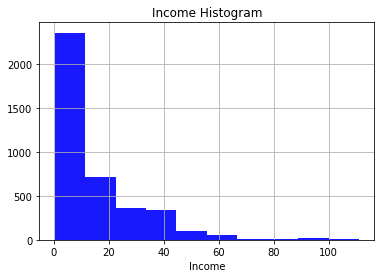

In [286]:
#plt.hist(new_dataset['growth_rate'], bins=30, density=True, alpha=0.8, histtype='stepfilled', color='steelblue')
#plt.hist(final_data['income'], bins=30, density=True, alpha=0.8, histtype='stepfilled', color='steelblue')
plt.xlabel("Income")
plt.title("Income Histogram")
final_data['income'].hist(alpha=0.9, color='blue')

Text(0.5,1,'Relationship between Child Mortality and Growth Rate')

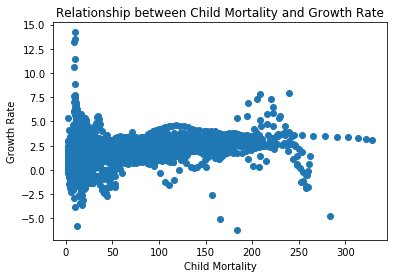

In [287]:
plt.scatter(final_data["child_mortality"],final_data["growth_rate"])
plt.xlabel("Child Mortality")
plt.ylabel("Growth Rate")
plt.title("Relationship between Child Mortality and Growth Rate")


Text(0,0.5,'Growth Rate')

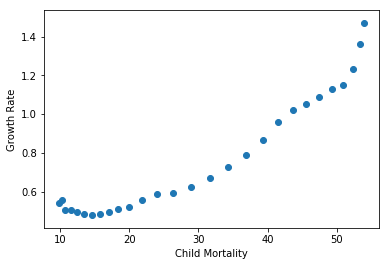

In [288]:
#select a country
China = final_data.loc[final_data['country'] == 'China']
plt.scatter(China["child_mortality"],China["growth_rate"])
plt.xlabel("Child Mortality")
plt.ylabel("Growth Rate")

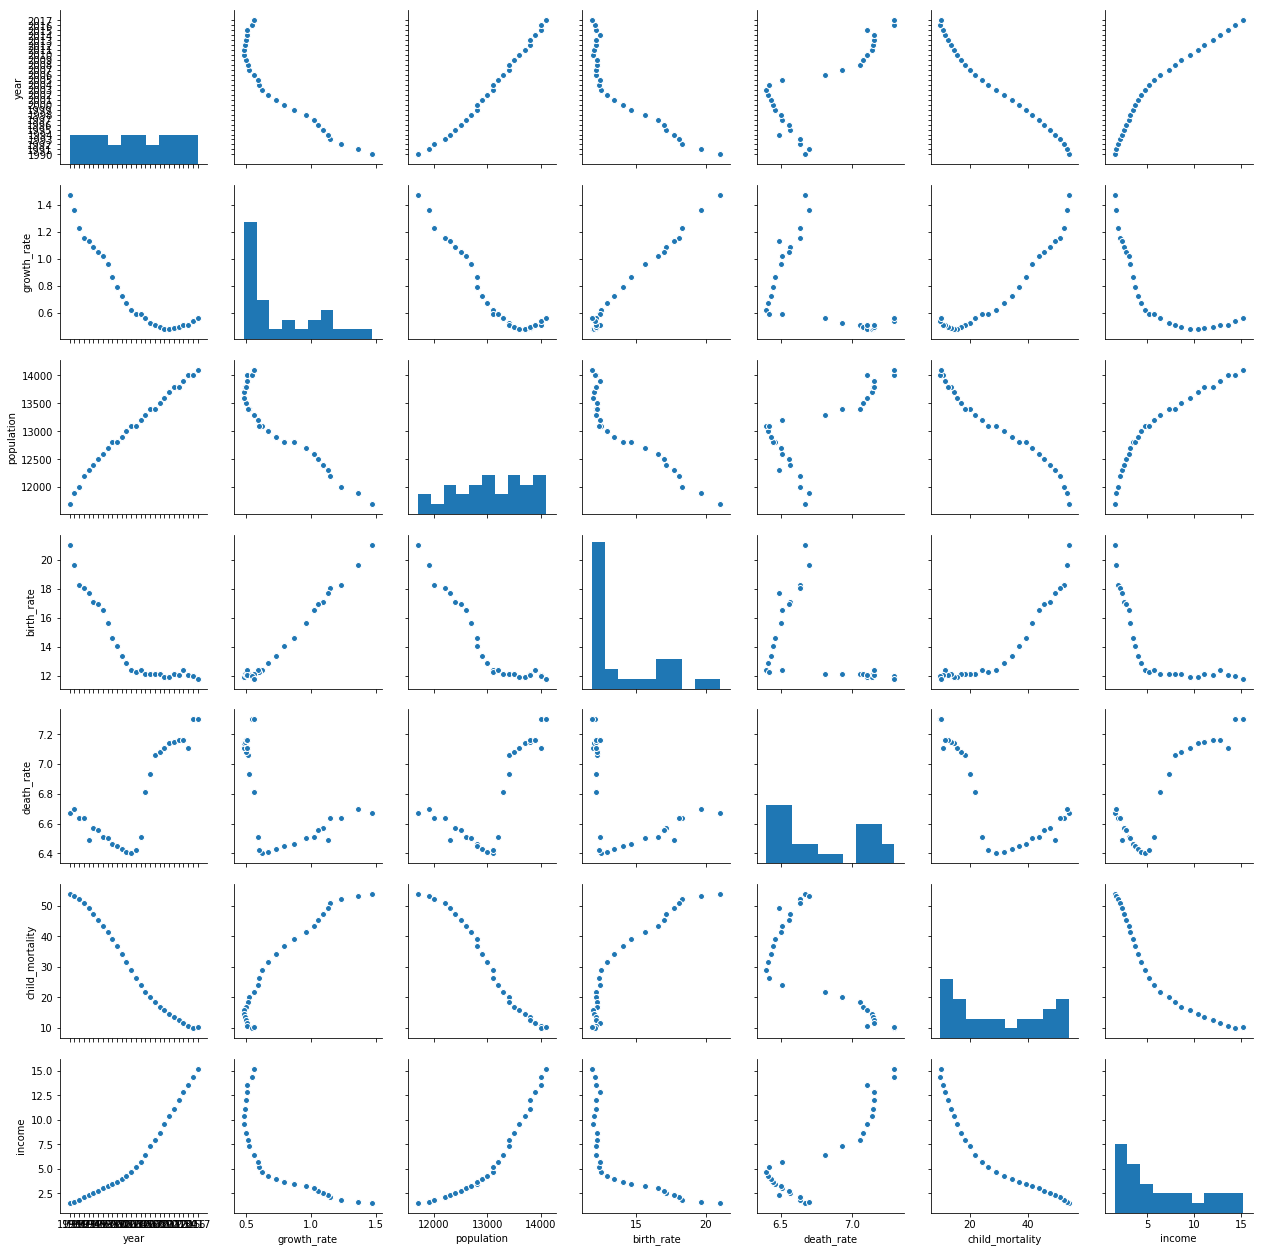

In [289]:
sns.pairplot(China[['year','growth_rate','population','birth_rate','death_rate','child_mortality','income']])

Text(0,0.5,'Growth Rate')

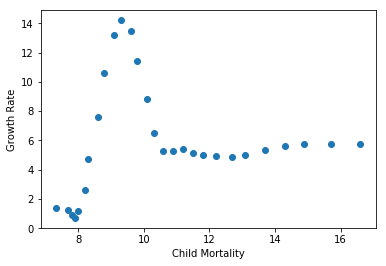

In [290]:
UAE = final_data.loc[final_data['country'] == 'United Arab Emirates']
plt.scatter(UAE["child_mortality"],UAE["growth_rate"])
plt.xlabel("Child Mortality")
plt.ylabel("Growth Rate")

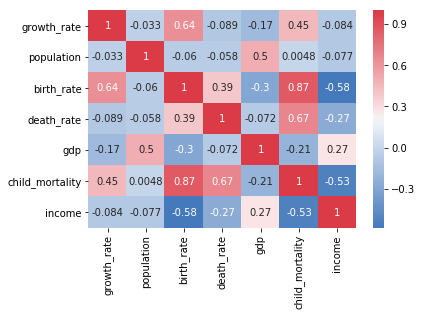

In [291]:
corr = final_data.loc[:,final_data.dtypes == 'float64'].corr()
sns.heatmap(corr, annot = True, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(250, 10, as_cmap=True))

In [292]:
#pairwise corr for each country
final_data.groupby(['country']).corr()

birth_rate  child_mortality  death_rate  \
country                                                                        
Albania             birth_rate         1.000000         0.983946   -0.620481   
                    child_mortality    0.983946         1.000000   -0.741409   
                    death_rate        -0.620481        -0.741409    1.000000   
                    gdp               -0.912049        -0.956929    0.839634   
                    growth_rate        0.159639         0.104480    0.119735   
                    income            -0.900881        -0.953033    0.862393   
                    population         0.879652         0.931364   -0.844691   
Algeria             birth_rate         1.000000         0.305132    0.684159   
                    child_mortality    0.305132         1.000000    0.886771   
                    death_rate         0.684159         0.886771    1.000000   
                    gdp               -0.192782        -0.974616   -0.802874   
                    growth_rate        0.976687         0.215040    0.629104   
                    income            -0.145273        -0.954926   -0.792702   
                    population        -0.300193        -0.978614   -0.840220   
Angola              birth_rate         1.000000         0.973134    0.970389   
                    child_mortality    0.973134         1.000000    0.969719   
                    death_rate         0.970389         0.969719    1.000000   
                    gdp               -0.957595        -0.992829   -0.947403   
                    growth_rate       -0.591911        -0.674817   -0.724220   
                    income            -0.836874        -0.920721   -0.853447   
                    population        -0.995854        -0.986557   -0.972374   
Antigua and Barbuda birth_rate         1.000000         0.663179    0.810356   
                    child_mortality    0.663179         1.000000    0.945662   
                    death_rate         0.810356         0.945662    1.000000   
                    gdp               -0.717965        -0.911721   -0.916061   
                    growth_rate        0.639005         0.328492    0.607479   
                    income            -0.521062        -0.692294   -0.694647   
                    population        -0.758722        -0.985985   -0.979228   
Argentina           birth_rate         1.000000         0.997025    0.983837   
                    child_mortality    0.997025         1.000000    0.986046   
...                                         ...              ...         ...   
Uruguay             income            -0.886599        -0.906322   -0.641673   
                    population        -0.968563        -0.957560   -0.875959   
Uzbekistan          birth_rate         1.000000         0.597819    0.801517   
                    child_mortality    0.597819         1.000000    0.888236   
                    death_rate         0.801517         0.888236    1.000000   
                    gdp               -0.380352        -0.941256   -0.742996   
                    growth_rate        0.624544         0.101819    0.318321   
                    income            -0.311450        -0.925013   -0.717868   
                    population        -0.697933        -0.980977   -0.901279   
Vanuatu             birth_rate         1.000000         0.737889    0.978262   
                    child_mortality    0.737889         1.000000    0.805545   
                    death_rate         0.978262         0.805545    1.000000   
                    gdp               -0.967009        -0.661796   -0.917508   
                    growth_rate        0.255264         0.336748    0.314621   
                    income            -0.747572        -0.437270   -0.718723   
                    population        -0.982887        -0.706793   -0.936632   
Zambia              birth_rate         1.000000         0.963657    0.988676   
                    child_mortality  

In [293]:
#population growth rate variance
var = final_data.groupby('country')['growth_rate'].var()
var.describe()

count    142.000000
mean       0.563968
std        1.681057
min        0.001765
25%        0.053269
50%        0.114770
75%        0.266903
max       13.987854
Name: growth_rate, dtype: float64